# [Product Recommendations](https://pub.towardsai.net/product-recommendations-321a0e7c7f7b)

### Build and Train a Personalized Recommender Engine with Amazon SageMaker Factorization Machines

**This is `Notebook Part 1`**

[Click here for `Notebook Part 2`](https://github.com/peggy1502/FM-Recommender-Engine/blob/main/rating/fm_v5_part2.ipynb)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time

import boto3
#import sagemaker
#import sagemaker.amazon.common as smac

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 50)  # default is 50

In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.19.5
pandas version: 1.3.3


# Read Dataset

In [3]:
# Set "usecols" to prevent the following error:
# ParserError: Error tokenizing data. C error: Expected 15 fields in line 1598, saw 22

df_pc = pd.read_csv("../input/amazon-customer-reviews/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv", 
                 sep="\t", usecols=range(0, 15))
df_ma = pd.read_csv("../input/amazon-customer-reviews/amazon_reviews_us_Major_Appliances_v1_00.tsv", 
                 sep="\t", usecols=range(0, 15))

df = pd.concat([df_pc, df_ma], axis=0)
print("Total records:", df.shape[0], "\n")
print("Sample records:\n")
df.sample(5)

Total records: 182766 

Sample records:



,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
31773,US,11397981,R2ICXB10GVUGDH,B0006VJ6TO,412568457,Body Back Company’s Body Back Buddy Trigger Po...,Personal_Care_Appliances,5,0,0,N,Y,like having a private massuse.,No more rubbing my back on door jams refrigera...,2014-01-25
11247,US,36011591,R3TOBNLUTI5VFP,B00O2MB7BS,960251524,Danby products,Major Appliances,5,142,157,N,Y,Nice looking and fits home-brew kegs,After I placed it in our basement I just let i...,2015-05-28
75659,US,41516854,RQ5LKM4QN78LW,B0018XPHOW,96711079,NEW - Black 36 lb Digital Postal Scale XP Seri...,Personal_Care_Appliances,3,6,6,N,Y,Okay product - great customer service,I bought this scale and like the versatility -...,2008-07-30
54472,US,37700233,R30YVJ9D22NR4N,B000KRID5W,315609243,Mediflow Chiroflow Travel Pillow,Personal_Care_Appliances,3,3,5,N,Y,Too big for air travel,The idea of this pillow is good as well as the...,2011-11-12
69947,US,35430629,R2S1BDECANPY6L,B001ES70QO,187176269,Remington R-800 MicroFlex Rotary Shaver,Personal_Care_Appliances,5,4,4,N,Y,Great Choice,I purchased the Rotary Shaver for my husband f...,2009-05-08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182766 entries, 0 to 96839
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        182766 non-null  object
 1   customer_id        182766 non-null  int64 
 2   review_id          182766 non-null  object
 3   product_id         182766 non-null  object
 4   product_parent     182766 non-null  int64 
 5   product_title      182762 non-null  object
 6   product_category   182766 non-null  object
 7   star_rating        182766 non-null  int64 
 8   helpful_votes      182766 non-null  int64 
 9   total_votes        182766 non-null  int64 
 10  vine               182766 non-null  object
 11  verified_purchase  182766 non-null  object
 12  review_headline    182764 non-null  object
 13  review_body        182759 non-null  object
 14  review_date        182765 non-null  object
dtypes: int64(5), object(10)
memory usage: 22.3+ MB


# Data Cleaning

### (i) Check Duplicates

A customer may have more than one review and rating for a particular product.

In [5]:
temp = df.groupby(["customer_id","product_id", "product_title", "product_category"]).nunique()["review_id"]
temp = temp.loc[temp > 1].reset_index().rename(columns={'review_id': 'unique_reviews'})
print("Number of records with duplicates:", temp.shape[0], "\n")
temp

Number of records with duplicates: 50 



,customer_id,product_id,product_title,product_category,unique_reviews
0,952385,B000WTWZPC,Broan QS330AA QS3 Series Range Hood,Major Appliances,2
1,7064850,B00BLDHH92,Frigidaire FPHB2899PFProfessional 27.7 Cu. Ft....,Major Appliances,2
2,8452567,B001O2A2HY,Woun'Dres Collagen Hydrogel,Personal_Care_Appliances,2
3,16594110,B00OSAUYTA,Psoriasis & Eczema Cream 4oz Advanced Healing ...,Personal_Care_Appliances,2
4,17795981,B002ZHSBXY,Whirlpool Refrigerator Lower Meat Pan/Crisper ...,Major Appliances,2
5,21317560,B000I00SEU,Broan 36W in. Ventless Under Cabinet Range Hood,Major Appliances,2
6,25348103,B000195ZKA,HAIER HDP18PA 6-Place Setting Compact Dishwash...,Major Appliances,2
7,27004950,B0001DBD1Q,Emergency Response Unit 900 MHZ,Personal_Care_Appliances,2
8,27876976,B0002KXMT4,Haier HLP21N 6.6-Pound Pulsator Wash with Stai...,Major Appliances,2
9,29768874,B000068PBJ,Norelco 8894 XL Spectra shaver Limited Edition...,Personal_Care_Appliances,2


In [6]:
# Example of customer with more than one review and rating for a particular product.
df.loc[(df["customer_id"]==51074560) & (df["product_id"]=="B00005ASFO")]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
85472,US,51074560,R2YZ6GYK330APD,B00005ASFO,83473674,Taylor Lithium 0935 Professional Digital Platf...,Personal_Care_Appliances,2,3,3,N,Y,A disappointment after 1 year of use,We've lived with this scale for about a year (...,2002-11-28
85767,US,51074560,R3MMVJJ5577YSX,B00005ASFO,83473674,Taylor Lithium 0935 Professional Digital Platf...,Personal_Care_Appliances,4,26,26,N,Y,A test run,Pros: Accurate &amp; precise. Easy to read &am...,2001-09-13


### Remove Duplicates

We will keep only the most recent review and rating for a particular customer and product.

In [7]:
df.sort_values(by=['customer_id', 'product_id', 'review_date'], inplace=True)

# Example of customer with more than one review and rating for a particular product (after sorting).
df.loc[(df["customer_id"]==51074560) & (df["product_id"]=="B00005ASFO")]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
85767,US,51074560,R3MMVJJ5577YSX,B00005ASFO,83473674,Taylor Lithium 0935 Professional Digital Platf...,Personal_Care_Appliances,4,26,26,N,Y,A test run,Pros: Accurate &amp; precise. Easy to read &am...,2001-09-13
85472,US,51074560,R2YZ6GYK330APD,B00005ASFO,83473674,Taylor Lithium 0935 Professional Digital Platf...,Personal_Care_Appliances,2,3,3,N,Y,A disappointment after 1 year of use,We've lived with this scale for about a year (...,2002-11-28


In [8]:
# Keep only the most recent review and rating for a particular customer and product.
df.drop_duplicates(['customer_id', 'product_id'], keep='last', inplace=True)

print("Dataset after dropping duplicates, number of rows and columns:", df.shape, "\n")

Dataset after dropping duplicates, number of rows and columns: (182716, 15) 



In [9]:
# Example of customer with more than one review and rating for a particular product (after dropping duplicate).
df.loc[(df["customer_id"]==51074560) & (df["product_id"]=="B00005ASFO")]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
85472,US,51074560,R2YZ6GYK330APD,B00005ASFO,83473674,Taylor Lithium 0935 Professional Digital Platf...,Personal_Care_Appliances,2,3,3,N,Y,A disappointment after 1 year of use,We've lived with this scale for about a year (...,2002-11-28


### (ii) Check Missing Data

In [10]:
df.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        4
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          7
review_date          1
dtype: int64

In [11]:
# Replace missing value for product_title with empty string.
df["product_title"].fillna("", inplace=True)

# # Drop rows where star_rating is null.
# df.dropna(axis=0, subset=["star_rating"], inplace=True) 

# # Replace missing value for verified_purchase with 'N'.
# df["verified_purchase"].fillna("N", inplace=True)

### (iii) Get only verified purchase records

In [12]:
df = df[df["verified_purchase"]=="Y"]

### (iv) Get the required columns only

In [13]:
columns = ["customer_id", "product_id", "product_title", "product_category", "star_rating"]
df = df[columns]

# Shuffle the DataFrame rows.
df = df.sample(frac=1, random_state=73)

In [14]:
# Check again to ensure no missing data.
df.isna().sum()

customer_id         0
product_id          0
product_title       0
product_category    0
star_rating         0
dtype: int64

# Some Basic EDA

### Distribution of Product Category

In [15]:
df['product_category'].value_counts()

Major Appliances            68791
Personal_Care_Appliances    63253
Name: product_category, dtype: int64

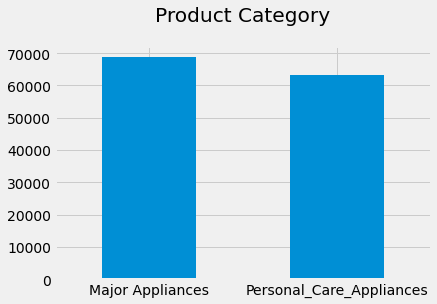

In [16]:
plt.style.use('fivethirtyeight')
df['product_category'].value_counts().sort_index().plot.bar(rot=0,
                                                            #ylabel="Count", 
                                                            #title="Product Category", 
                                                           )
plt.title("Product Category", y=1.08) # y pads the title upward.
plt.show()

### Distribution of Customers and Products by Product Category

In [17]:
temp1 = df.groupby(["product_category"]).nunique()["customer_id"].reset_index().rename(columns={'customer_id': 'unique_customers'})
temp2 = df.groupby(["product_category"]).nunique()["product_id"].reset_index().rename(columns={'product_id': 'unique_products'})
temp3 = pd.merge(temp1, temp2, on="product_category")
temp3

,product_category,unique_customers,unique_products
0,Major Appliances,66190,8346
1,Personal_Care_Appliances,61721,12558


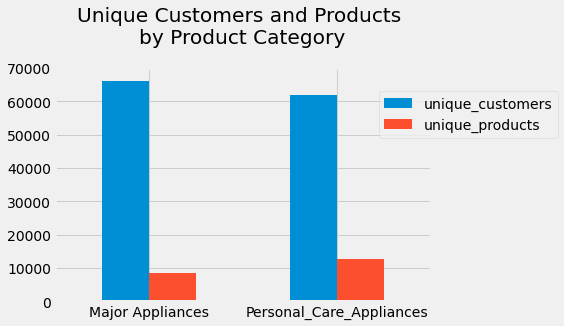

In [18]:
# To find ceiling of Count.
y1 = temp3["unique_customers"].max()
y2 = temp3["unique_products"].max()
y_max = y1 if y1>y2 else y2
y_max = np.ceil(y_max/10000)*10000 # Round up to the nearest 10k.

temp3.plot(x="product_category", kind="bar", stacked=False,
           #title="Unique Customers and Products \nby Product Category",
           ylabel="", ylim=(0, y_max),
           xlabel="", rot=0)

plt.legend(loc="center", bbox_to_anchor=(1.1, 0.8))
plt.title("Unique Customers and Products \nby Product Category", y=1.08) # y pads the title upward.
plt.show()

### Distribution of Star Rating

In [19]:
df['star_rating'].value_counts()

5    78784
4    22481
1    13834
3    10235
2     6710
Name: star_rating, dtype: int64

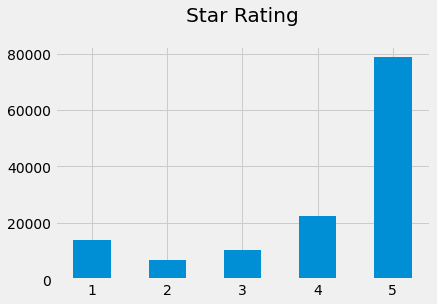

In [20]:
plt.style.use('fivethirtyeight')
df['star_rating'].value_counts().sort_index().plot.bar(rot=0,
                                                       # ylabel="Count", 
                                                       #title="Star Rating", 
                                                       )
plt.title("Star Rating", y=1.08) # y pads the title upward.
plt.show()

### Number of unique customers and products

In [21]:
print("Unique customers:", df["customer_id"].nunique())
print("Unique products:", df["product_id"].nunique())

Unique customers: 127061
Unique products: 20904


In [22]:
# Number of unique products rated by N customers.

temp = df.groupby(["customer_id"]).nunique()["product_id"]
temp = temp.loc[temp > 1].reset_index().rename(columns={'product_id': 'unique_products'})
temp["unique_products"].value_counts().sort_index()

2    3961
3     367
4      54
5      22
6       5
7       1
8       1
Name: unique_products, dtype: int64

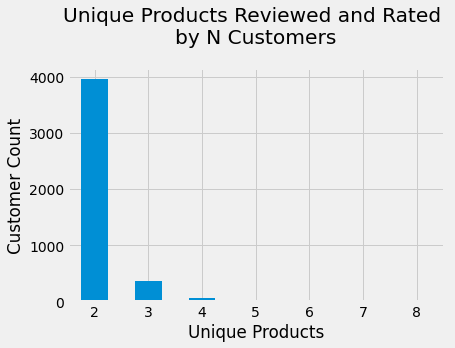

In [23]:
temp["unique_products"].value_counts().sort_index().plot.bar(ylabel="Customer Count", 
                                                             xlabel="Unique Products", rot=0)
plt.title("Unique Products Reviewed and Rated \nby N Customers", y=1.08) # y pads the title upward.
plt.show()

Above, we can see that most customers (almost 4000 customers) have reviewed and rated 2 unique products.

367 customers have reviewed and rated 3 unique products, and so on.

In [24]:
# Number of unique customers who rated the products.

temp = df.groupby(["product_id"]).nunique()["customer_id"]
temp = temp.loc[temp > 1].reset_index().rename(columns={'customer_id': 'unique_customers'})
temp["unique_customers"].value_counts().sort_index()

2       3188
3       1520
4        899
5        655
6        462
        ... 
789        1
946        1
1164       1
1694       1
1937       1
Name: unique_customers, Length: 215, dtype: int64

# Create Sparse Matrix

### Perform one-hot encoding for categorical data

In [25]:
ohe = OneHotEncoder(handle_unknown = "ignore")
ohe_cols = ["customer_id", "product_id", "product_category"]
ohe_features = ohe.fit_transform(df[ohe_cols])
ohe_features

<132044x147967 sparse matrix of type '<class 'numpy.float64'>'
	with 396132 stored elements in Compressed Sparse Row format>

In [26]:
ohe_feature_names = ohe.get_feature_names()
df_ohe = pd.DataFrame(data = ohe_features.toarray(), index=range(len(df)), columns=ohe_feature_names)
df_ohe

,x0_10097,x0_10150,x0_10470,x0_10947,x0_11007,x0_11344,x0_11396,x0_11804,x0_12185,x0_12404,x0_12674,x0_13044,x0_13112,x0_14147,x0_14408,x0_14864,x0_14889,x0_14977,x0_15033,x0_15269,x0_15715,x0_16164,x0_16454,x0_16518,x0_16875,...,x1_B00ZPL5CCA,x1_B00ZPZ7KNA,x1_B00ZSGZOY8,x1_B00ZYGB874,x1_B0108O3IW4,x1_B010CE497I,x1_B010CRR3V4,x1_B010FC4F44,x1_B010OY5TQQ,x1_B010PR0OM6,x1_B010RGWNDI,x1_B010W0PM6E,x1_B010Y5G5EU,x1_B0118Q011M,x1_B011J79PNK,x1_B011JCDFOA,x1_B011M6UYMO,x1_B011OI71X0,x1_B01291WU3W,x1_B012B9FT9E,x1_B012BO5ETY,x1_B012E7L3UM,x1_B01FWK8ARW,x2_Major Appliances,x2_Personal_Care_Appliances
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
132041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Perform TF-IDF encoding for text data

In [27]:
# min_df=2: Ignore terms that appear in less than 2 documents.
vectorizer = TfidfVectorizer(min_df=2)  
vectorizer.fit(df["product_title"].unique())
tfidf_features = vectorizer.transform(df["product_title"])
tfidf_features

<132044x8671 sparse matrix of type '<class 'numpy.float64'>'
	with 1071103 stored elements in Compressed Sparse Row format>

In [28]:
tfidf_feature_names = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_features.toarray(), index=range(len(df)), columns=tfidf_feature_names)
df_tfidfvect

,00,000,0000,00003,00003a,00003b,00003g,00012a,00012b,00019a,00020a,00020b,00054a,001,00159,00159a,00196a,002,003a,003d,004,005,00887a,0090trp,01,...,zcifi,zebra,zeiss,zenith,zensah,zephyr,zero,zest,zig,ziiiro,zim,zinc,zip,zipfizz,zipper,zippered,zippo,zojirushi,zone,zones,zoom,zoomable,zuma,zyrcons,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sparse matrix for all features

In [29]:
# Stack all the sparse matrices side by side.

X = hstack([ohe_features, tfidf_features], format="csr", dtype="float32")
X

<132044x156638 sparse matrix of type '<class 'numpy.float32'>'
	with 1467235 stored elements in Compressed Sparse Row format>

In [30]:
y = df["star_rating"].values.astype("float32")
y

array([3., 2., 4., ..., 5., 5., 5.], dtype=float32)

In [31]:
total = X.shape[0] * X.shape[1]
non_zero = X.nnz
sparsity = (total - non_zero) / total

print("Total elements:", total)
print("Non-zero elements:", non_zero)
print("Sparsity:", round(sparsity*100, 4), "%")

Total elements: 20683108072
Non-zero elements: 1467235
Sparsity: 99.9929 %


# Splitting Data into Training and Test Set

In [32]:
# By default, shuffle=True.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=73)           

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape, "\n")
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (105635, 156638)
Shape of y_train: (105635,) 

Shape of X_test: (26409, 156638)
Shape of y_test: (26409,)


### Save local files

In [33]:
# Save the dataframe to csv.
df.to_csv("fm_preprocessed.csv", index=False)

# save_npz: Save a sparse matrix for X_train and X_test to a file using .npz format.
# np.savez: Save array for y_test into a single file in uncompressed .npz format.
save_npz("X_train.npz", X_train) 
save_npz("X_test.npz", X_test)
np.savez("y_train.npz", y_train) 
np.savez("y_test.npz", y_test)

# Save the feature dimension to a text file.
feature_dim = X.shape[1]
with open("feature_dim.txt", "w") as f:
    f.write(str(feature_dim))

[**Click here to continue on `Notebook Part 2` for**](https://github.com/peggy1502/FM-Recommender-Engine/blob/main/rating/fm_v5_part2.ipynb)

- Creating Sparse RecordIO File
- Training Job & Hyperparameters
- Train Model
- Deploy Model
- Model Inference